In [1]:
tickers = ['NVDA']

# Strike Price
K = 920

# Days until Expiration
d = 14

# Stock Dividend Yield
q = 0

# Risk Free
r = 0.0425

# Stock Implied Volatility
implied_vol = 0.41

Start = (2007,1,1)
End = (2023,12,31)

# Black Scholes Merton 
$$
d_1 = \frac{\ln(\frac{S}{K}) + (r - q + \frac{stdev^2}{2})t}{stdev \cdot \sqrt{t}}
$$

$$
d_2 = d_1 - s \cdot \sqrt{t} = \frac{\ln(\frac{S}{K}) + (r - q - \frac{stdev^2}{2})t}{stdev \cdot \sqrt{t}}
$$

$$
\textbf{C} = N(d_1)S - N(d_2)Ke^{-rt} 
$$
$$
\textbf{P} = N(-d_2)Ke^{-rt} - N(-d_1)S
$$
S = Current Stock Price
\
K = Option Strike Price
\
t = Time Horizon
\
r = Risk-free Rate
\
q = Dividend Yield
\
stdev = Standard Deviation
\
N = Normal Distribution
\
e = exponent
\
d1 & d2 = Cumulative Distribution Functions
\
C = Calls Premium
\
P = Puts Premium

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import wb, data
import yfinance as yf
yf.pdr_override()

from datetime import date as date, timedelta
import datetime as dt

start = dt.datetime(*Start)
end = dt.datetime(*End)
today = date.today()
yesterday = today - timedelta(days=1)

stock_data = pd.DataFrame()
for t in tickers: 
    stock_data [t] = data.get_data_yahoo(t, start)['Adj Close']

log_returns = np.log(1 + stock_data.pct_change())
stdev = log_returns.std() * 250**0.5

# Time horizon
T = d/250

# Current Price
S = stock_data.iloc[-1]

def d1(S, K, r, q, stdev, T):
    return (np.log(S / K) + (r - q + (stdev ** 2) / 2) * T) / (stdev * np.sqrt(T))

def d2(S, K, r, q, stdev, T):
    return (np.log(S / K) + (r - q - (stdev ** 2) / 2) * T) / (stdev * np.sqrt(T))

def BSM_calls(S, K, r, q, stdev, T):
    d1_value = d1(S, K, r, q, stdev, T)
    d2_value = d2(S, K, r, q, stdev, T)
    return (S * np.exp(-q * T) * norm.cdf(d1_value)) - (K * np.exp(-r * T) * norm.cdf(d2_value))

def BSM_puts(S, K, r, q, stdev, T):
    d1_value = d1(S, K, r, q, stdev, T)
    d2_value = d2(S, K, r, q, stdev, T)
    return (K * np.exp(-r * T) * norm.cdf(-d2_value)) - (S * np.exp(-q * T) * norm.cdf(-d1_value))

calls = BSM_calls(S, K, r, q, implied_vol, T)
puts = BSM_puts(S, K, r, q, implied_vol, T)

print('Previous close price:', S)
print('\n')
print('Call option premium:', calls)
print('\n')
print('Put option premium:', puts)

[*********************100%%**********************]  1 of 1 completed

Previous close price: NVDA    881.859985
Name: 2024-04-12 00:00:00, dtype: float64


Call option premium: NVDA    19.748807
Name: 2024-04-12 00:00:00, dtype: float64


Put option premium: NVDA    55.701825
Name: 2024-04-12 00:00:00, dtype: float64


# Monte Carlo - Euler Discretization 

<br /><br />
$$
{\LARGE S_t = S_{t-1} \mathbin{\cdot} e^{((r - \frac{1}{2} \cdot stdev^2) \mathbin{\cdot} \delta_t + stdev \mathbin{\cdot} \sqrt{\delta_t} \mathbin{\cdot} Z_t)}  }
$$
<br /><br />

S_t = Today Stock Price
\
S_t-1 = Yesterday Stock Price
\
e = Exponent
\
r = Risk-free Rate
\
stdev = Standard Deviation
\
Delta t = Fixed Time Interval
\
Z = Random Variable

Euler Discretization Call Option Price: 19.00
Euler Discretization Put Option Price: 56.04


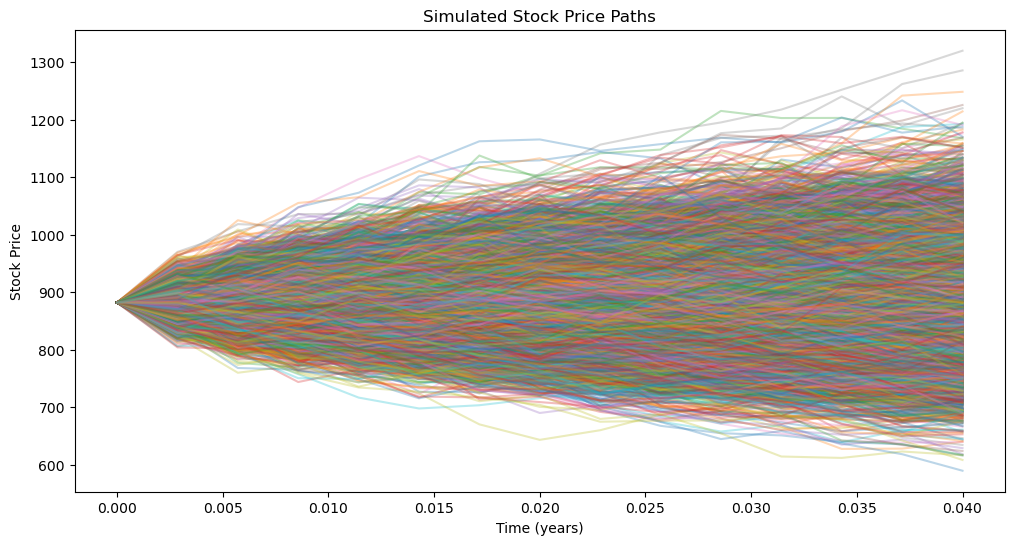

In [3]:
stdev = np.array(stdev)

# Calculate the time horizon based on the number of trading days until expiration
trading_days = 0
current_date = today
while current_date <= today + timedelta(days=d):
    if current_date.weekday() < 5:  # Exclude weekends
        trading_days += 1
    current_date += timedelta(days=1)
T = trading_days / 250  # Time horizon in years

# Monte Carlo Euler Discretization
t_intervals = d  # Number of time steps (days)
delta_t = T / t_intervals
iterations = 10000  # Number of simulations

Z = np.random.standard_normal((iterations, t_intervals + 1))
S = np.zeros_like(Z)
S0 = stock_data.iloc[-1]
S[:, 0] = S0

for t in range(1, t_intervals + 1):
    S[:, t] = S[:, t-1] * np.exp((r - 0.5 * (stdev ** 2)) * delta_t + stdev * (delta_t**0.5) * Z[:, t])

# Payout
call_payoff = np.maximum(S[:, -1] - K, 0)
put_payoff = np.maximum(K - S[:, -1], 0)

call_price = np.exp(-r * T) * np.mean(call_payoff)
put_price = np.exp(-r * T) * np.mean(put_payoff)

print(f"Euler Discretization Call Option Price: {call_price:.2f}")
print(f"Euler Discretization Put Option Price: {put_price:.2f}")

# Plot the simulated stock price paths
plt.figure(figsize=(12, 6))
x = np.linspace(0, T, t_intervals + 1)
plt.plot(x, S.T, alpha=0.3)
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Paths')
plt.show()


In [4]:
# Bisection Method to calcualte implied volatility 


# Current Price
S = stock_data.iloc[-1]

def d1(S, K, r, q, stdev, T):
    return (np.log(S / K) + (r - q + (stdev ** 2) / 2) * T) / (stdev * np.sqrt(T))

def d2(S, K, r, q, stdev, T):
    return (np.log(S / K) + (r - q - (stdev ** 2) / 2) * T) / (stdev * np.sqrt(T))

def BSM_calls(S, K, r, q, stdev, T):
    d1_value = d1(S, K, r, q, stdev, T)
    d2_value = d2(S, K, r, q, stdev, T)
    return (S * np.exp(-q * T) * norm.cdf(d1_value)) - (K * np.exp(-r * T) * norm.cdf(d2_value))

def BSM_puts(S, K, r, q, stdev, T):
    d1_value = d1(S, K, r, q, stdev, T)
    d2_value = d2(S, K, r, q, stdev, T)
    return (K * np.exp(-r * T) * norm.cdf(-d2_value)) - (S * np.exp(-q * T) * norm.cdf(-d1_value))

def implied_volatility(S, K, r, q, T, option_price, option_type):
    """
    Calculate the implied volatility using the bisection method.
    """
    def objective_function(sigma):
        if option_type == 'call':
            return float(BSM_calls(S, K, r, q, sigma, T).iloc[0] - option_price)
        else:
            return float(BSM_puts(S, K, r, q, sigma, T).iloc[0] - option_price)

    sigma_low = 0.01
    sigma_high = 1
    tol = 1e-7

    while abs(sigma_high - sigma_low) > tol:
        sigma_mid = (sigma_low + sigma_high) / 2
        if objective_function(sigma_low) * objective_function(sigma_mid) < 0:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid

    return (sigma_low + sigma_high) / 2

# Calculate initial call and put option premiums
call_premium = BSM_calls(S, K, r, q, stdev, T)
put_premium = BSM_puts(S, K, r, q, stdev, T)

# Calculate implied volatility using the initial option premiums
call_iv = implied_volatility(S, K, r, q, T, call_premium.iloc[0], 'call')
put_iv = implied_volatility(S, K, r, q, T, put_premium.iloc[0], 'put')

# Calculate final call and put option premiums using the implied volatility
calls = BSM_calls(S, K, r, q, call_iv, T)
puts = BSM_puts(S, K, r, q, put_iv, T)

print('Previous close price:', S)
print('\n')
print('Call option premium:', calls)
print('\n')
print('Put option premium:', puts)


Previous close price: NVDA    881.859985
Name: 2024-04-12 00:00:00, dtype: float64


Call option premium: NVDA    19.800983
Name: 2024-04-12 00:00:00, dtype: float64


Put option premium: NVDA    56.378327
Name: 2024-04-12 00:00:00, dtype: float64
